In this notebook, we generate a Feed Forward Neural Network.

In [1]:
import os # Useful for running command line within python
import pandas as pd ## Useful for data manipulation

import torch ## Pytorch is the deep learning library that we will be using
import torch.nn as nn # Neural network module
import torch.nn.functional as F ## Functional module
import torchmetrics ## Torchmetrics is a library that contains metrics for evaluating models
from torch.utils.data import DataLoader, random_split
#from torchvision.datasets.folder import default_loader
from torch.utils.data.dataset import Dataset

import pytorch_lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torchmetrics.regression import MeanSquaredError
from torchsummary import summary

from torch.nn import ReLU, Sequential
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
def transform_to_range(inputs,historic, y1=1,y0=-1):
    n_inputs=inputs.shape[1]
    names_inputs=historic.columns
    slope=torch.zeros(n_inputs)
    b_array=torch.zeros(n_inputs)
    for i in range(n_inputs):
        x1=historic[names_inputs[i+1]][1]
        x0=historic[names_inputs[i+1]][0]
        slope[i]=(y1-y0)/(x1-x0)
        b_array[i]=-x0*slope[i]+y0
                    
    return inputs*slope+b_array

Construct the trainset, valset, and testset.

In [3]:
## We are creating a custom dataset class
class WeatherData(Dataset):

    def __init__(self, csv_inputs, csv_outputs,csv_historic,y1=1,y0=-1):
        """
        Arguments:
            csv_inputs (string): Path to the csv file of the inputs of the NN.
            csv_outputs (string): Path to the csv file of temperatures 24 and 48 hours after measurement .
            csv_historic (string): Path to the csv file of historic weather data.
        """
        
        input_data = pd.read_csv(csv_inputs)
        output_data= pd.read_csv(csv_outputs)
        historic= pd.read_csv(csv_historic)
        
        
        ## Transform input data
        n=len(input_data)
        minutes=[datetime.datetime.strptime(input_data["local_time"][i], '%Y-%m-%d %H:%M:%S').minute for i in range(n)]
        input_data["local_time"]=minutes
        self.inputs=transform_to_range(torch.tensor(input_data.values.astype(np.float32)),historic,y1=y1,y0=y0)
        
        #Transform output data
        x1_temperature=historic["Air_Temperature_in_degrees_C"][1]
        x0_temperature=historic["Air_Temperature_in_degrees_C"][0]
        slope_temperature=(y1-y0)/(x1_temperature-x0_temperature)
        b_temperature=-x0_temperature*slope_temperature+y0
        self.outputs=torch.tensor(output_data.values.astype(np.float32))*slope_temperature+b_temperature
    
        
        

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx:int):
        return self.inputs[idx],self.outputs[idx]

In [4]:
input_86077="./data/cleaned_data/86077_aws_plumber_data_inputs.csv"
output_86077="./data/cleaned_data/86077_aws_plumber_data_outputs.csv"
historic_path="./data/cleaned_data/Historical_data.csv"

In [5]:
dataset=WeatherData(input_86077,output_86077,historic_path)

In [6]:
trainset, valset, testset = random_split(dataset, [0.8, 0.1,0.1]) 

Define dataloaders

In [7]:
# Define a batch size of 16.
BATCH_SIZE = 64 #Just indicate the batch size

# Create Dataloaders again with features generated from pre-trained CNN model.
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)
valloader = DataLoader(valset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [8]:
## Feed Forward Neural Network

class feed_forward(pl.LightningModule):
    def __init__(self, n, learning_rate=1e-3, traindataloader=None, valdataloader=None, testdataloader=None):
        ## n is the number of inputs
        super().__init__()
        
        # define learning rate
        self.learning_rate = learning_rate ## Just the numerical value of the learning rate

        # define loss function (Huber loss). This function is robust against outliers
        self.loss_fun = nn.HuberLoss() ## The function to calculate the loss

        # define neural layers
        ## The architectures follows the NN defined in the Urban Heat Island paper about Athens 
        self.linear1 =  nn.Linear(n, 30) ## 
        self.linear2 =  nn.Linear(30, 30) ##
        self.linear3= nn.Linear(30,2) ## This layer makes a prediction.
        
        # Create ReLU Activation Layer
        self.relu=nn.ReLU() ####

        # We calculate the mean square error as a perfomance metric
        
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()

        # Define dataloaders
        self.traindataloader = traindataloader ### I am just passing the corresponding dataloader
        self.valdataloader = valdataloader   ### I am just passing the corresponding dataloader
        self.testdataloader = testdataloader ### I am just passing the corresponding dataloader

    def forward(self, x):
        
        out1=self.relu(self.linear1(x))
        out2=self.relu(self.linear2(out1))
        out=self.linear3(out2)

        return out # return the output

    def training_step(self, batch, batch_idx):

        # Make predictions
        x,y=batch ## The batch should come from the CovidDataset class
        # Do the prediction
        
        y_hat=self(x) ## This predicts the results from x

        # Calculate the loss
        # Apply the loss function here
        loss=self.loss_fun(y_hat,y) ## Calculate the loss with the function declared in this class
        ## Update the MSE
        self.train_mse.update(y_hat, y)
        
        
        # Record accuracy and loss
        # Calling self.log will surface up scalars for you in TensorBoard
        # You may add more logs as you think necessary
         
        ### In the next two lines the history of the loss and accuracy is logged
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_mse", self.train_mse, prog_bar=True, on_step=False, on_epoch=True)

        # Return the loss
        return loss ## 

    def validation_step(self, batch, batch_idx):
        
        ### I am going to reuse the code for the training
        x,y=batch 
        y_hat=self(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 
        ## Update the MSE
        self.val_mse.update(y_hat, y)


        # Record accuracy and loss
        # Log anything you think necessary
        ### Save the logs for the loss and for the accuracy
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_mse", self.val_mse, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        
        x,y=batch 
        y_hat=self(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 

        self.test_mse.update(y_hat, y) 

        # Record accuracy and loss
        # Log anything you think necessary
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_mse", self.test_mse, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx):
        
        x,y=batch
        # Do prediction
        y_hat=self(x)

        return y_hat,y,x # Return prediction, actual value and inputs  

    def configure_optimizers(self):
        # define optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        # return the train dataloader
        return  self.traindataloader ## Just return the traindataloader

    def val_dataloader(self):
        # return the validation dataloader
        return self.valdataloader  ### Just return the valdataloader

    def test_dataloader(self):
        # return the test dataloader
        return self.testdataloader  ## Just return the testdataloader

# Initialize the model

In [9]:
# Initialize the model by creating instance from Model class
feed_forward_model = feed_forward(11, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)

# Display a summary of the model's architecture
summary(feed_forward_model, (1,11)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 30]             360
              ReLU-2                [-1, 1, 30]               0
            Linear-3                [-1, 1, 30]             930
              ReLU-4                [-1, 1, 30]               0
            Linear-5                 [-1, 1, 2]              62
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [10]:
feed_forward_callback = ModelCheckpoint(
        monitor='val_mse',
        dirpath='.\\logs_feed_forward',
        save_top_k=1,
        mode='min',
        every_n_epochs=1)
# Monitor the validation mean square eror
# Specify a directory for checkpoints
# save the one best model
# Save the min. monitored quantity
# Monitor every 1 epoch


# Create a Trainer
n_epochs=100  ## I am defining the maximum number of epochs
feed_forward_trainer = pl.Trainer(accelerator = "auto",
                  max_epochs = n_epochs,
                  callbacks = [TQDMProgressBar(refresh_rate=20),feed_forward_callback],
                  logger = CSVLogger(save_dir=".\\logs_feed_forward"))


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
feed_forward_trainer.fit(feed_forward_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\logs_feed_forward exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fun  | HuberLoss        | 0     
1 | linear1   | Linear           | 360   
2 | linear2   | Linear           | 930   
3 | linear3   | Linear           | 62    
4 | relu      | ReLU             | 0     
5 | train_mse | MeanSquaredError | 0     
6 | val_mse   | MeanSquaredError | 0     
7 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [12]:
feed_forward_metrics =  pd.read_csv(feed_forward_trainer.logger.log_dir + "/metrics.csv") ###

feed_forward_metrics.set_index("epoch", inplace=True) ## Set the column epoch as the index of the DataFrame
feed_forward_metrics = feed_forward_metrics.groupby(level=0).sum()  ##It groups by epoch by summing the rows with the same epoch
## The previous line also make the NaN values disappear, as those are not considered in a sum.
feed_forward_metrics=feed_forward_metrics.drop("step", axis=1) # The column step lose its meaning while adding

Text(0, 0.5, 'Loss')

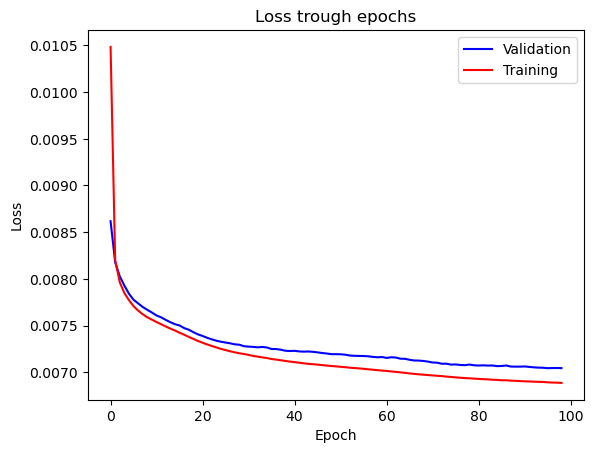

In [13]:
plt.plot(feed_forward_metrics["val_loss"][:-1],'b-', label="Validation")
plt.plot(feed_forward_metrics["train_loss"][:-1],'r-', label="Training")
plt.legend()
plt.title("Loss trough epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Now, a look at the Mean square error

Text(0, 0.5, 'MSE')

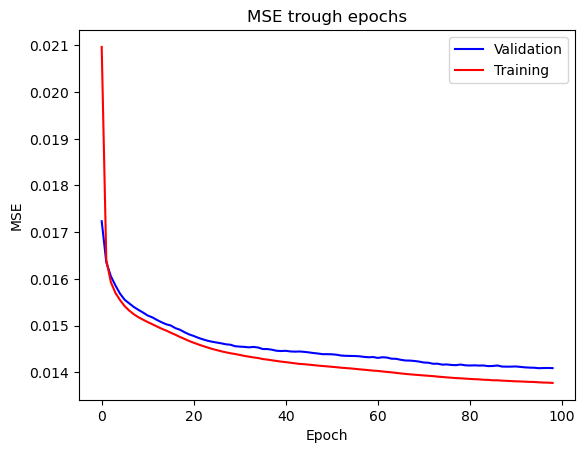

In [14]:
plt.plot(feed_forward_metrics["val_mse"][:-1],'b-', label="Validation")
plt.plot(feed_forward_metrics["train_mse"][:-1],'r-', label="Training")
plt.legend()
plt.title("MSE trough epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")

It seems that it has already converged around with a MSE of 0.0144

# Test the MSE

In [15]:
feed_forward_trainer.test(feed_forward_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.007034108508378267    │
│         test_mse          │   0.014068217016756535    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.007034108508378267, 'test_mse': 0.014068217016756535}]

# Add one more layer

In [16]:
## Feed Forward Neural Network

class feed_forward_3_layers(pl.LightningModule):
    def __init__(self, n, learning_rate=1e-3, traindataloader=None, valdataloader=None, testdataloader=None):
        ## n is the number of inputs
        super().__init__()
        
        # define learning rate
        self.learning_rate = learning_rate ## Just the numerical value of the learning rate

        # define loss function (Huber loss). This function is robust against outliers
        self.loss_fun = nn.HuberLoss() ## The function to calculate the loss

        # define neural layers
        ## The architectures follows the NN defined in the Urban Heat Island paper about Athens 
        self.linear1 =  nn.Linear(n, 30) ## 
        self.linear2 =  nn.Linear(30, 30) ##
        self.linear3= nn.Linear(30,30) ##
        self.linear4= nn.Linear(30,2) ## This layer makes a prediction
        
        # Create ReLU Activation Layer
        self.relu=nn.ReLU() ####

        # We calculate the mean square error as a perfomance metric
        
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()

        # Define dataloaders
        self.traindataloader = traindataloader ### I am just passing the corresponding dataloader
        self.valdataloader = valdataloader   ### I am just passing the corresponding dataloader
        self.testdataloader = testdataloader ### I am just passing the corresponding dataloader

    def forward(self, x):
        
        out1=self.relu(self.linear1(x))
        out2=self.relu(self.linear2(out1))
        out3=self.relu(self.linear3(out2))
        out=self.linear4(out3)

        return out # return the output

    def training_step(self, batch, batch_idx):

        # Make predictions
        x,y=batch ## The batch should come from the CovidDataset class
        # Do the prediction
        
        y_hat=self(x) ## This predicts the results from x

        # Calculate the loss
        # Apply the loss function here
        loss=self.loss_fun(y_hat,y) ## Calculate the loss with the function declared in this class
        ## Update the MSE
        self.train_mse.update(y_hat, y)
        
        
        # Record accuracy and loss
        # Calling self.log will surface up scalars for you in TensorBoard
        # You may add more logs as you think necessary
         
        ### In the next two lines the history of the loss and accuracy is logged
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_mse", self.train_mse, prog_bar=True, on_step=False, on_epoch=True)

        # Return the loss
        return loss ## 

    def validation_step(self, batch, batch_idx):
        
        ### I am going to reuse the code for the training
        x,y=batch 
        y_hat=self(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 
        ## Update the MSE
        self.val_mse.update(y_hat, y)


        # Record accuracy and loss
        # Log anything you think necessary
        ### Save the logs for the loss and for the accuracy
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_mse", self.val_mse, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        
        x,y=batch 
        y_hat=self(x) ## This predicts the results from x

        # Compute loss for each batch
        loss=self.loss_fun(y_hat,y) ## Calculate the loss 

        self.test_mse.update(y_hat, y) 

        # Record accuracy and loss
        # Log anything you think necessary
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_mse", self.test_mse, prog_bar=True, on_step=False, on_epoch=True)

    def predict_step(self, batch, batch_idx):
        
        x,y=batch
        # Do prediction
        y_hat=self(x)

        return y_hat,y,x # Return prediction, actual value and inputs  

    def configure_optimizers(self):
        # define optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        # return the train dataloader
        return  self.traindataloader ## Just return the traindataloader

    def val_dataloader(self):
        # return the validation dataloader
        return self.valdataloader  ### Just return the valdataloader

    def test_dataloader(self):
        # return the test dataloader
        return self.testdataloader  ## Just return the testdataloader

# Intialize deeper model

In [17]:
# Initialize the model by creating instance from Model class
feed_forward_deeper_model = feed_forward_3_layers(11, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)

# Display a summary of the model's architecture
summary(feed_forward_deeper_model, (1,11)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 30]             360
              ReLU-2                [-1, 1, 30]               0
            Linear-3                [-1, 1, 30]             930
              ReLU-4                [-1, 1, 30]               0
            Linear-5                [-1, 1, 30]             930
              ReLU-6                [-1, 1, 30]               0
            Linear-7                 [-1, 1, 2]              62
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [18]:
feed_forward_deeper_callback = ModelCheckpoint(
        monitor='val_mse',
        dirpath='.\\logs_feed_forward_deeper',
        save_top_k=1,
        mode='min',
        every_n_epochs=1)
# Monitor the validation mean square eror
# Specify a directory for checkpoints
# save the one best model
# Save the min. monitored quantity
# Monitor every 1 epoch


# Create a Trainer
n_epochs=100  ## I am defining the maximum number of epochs
feed_forward_deeper_trainer = pl.Trainer(accelerator = "auto",
                  max_epochs = n_epochs,
                  callbacks = [TQDMProgressBar(refresh_rate=20),feed_forward_deeper_callback],
                  logger = CSVLogger(save_dir=".\\logs_feed_forward_deeper"))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
feed_forward_deeper_trainer.fit(feed_forward_deeper_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\jaco0003\Documents\UrbanHeatIsland\logs_feed_forward_deeper exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fun  | HuberLoss        | 0     
1 | linear1   | Linear           | 360   
2 | linear2   | Linear           | 930   
3 | linear3   | Linear           | 930   
4 | linear4   | Linear           | 62    
5 | relu      | ReLU             | 0     
6 | train_mse | MeanSquaredError | 0     
7 | val_mse   | MeanSquaredError | 0     
8 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [20]:
feed_forward_deeper_metrics =  pd.read_csv(feed_forward_deeper_trainer.logger.log_dir + "/metrics.csv") ###

feed_forward_deeper_metrics.set_index("epoch", inplace=True) ## Set the column epoch as the index of the DataFrame
feed_forward_deeper_metrics = feed_forward_deeper_metrics.groupby(level=0).sum()  ##It groups by epoch by summing the rows with the same epoch
## The previous line also make the NaN values disappear, as those are not considered in a sum.
feed_forward_deeper_metrics=feed_forward_deeper_metrics.drop("step", axis=1) # The column step lose its meaning while adding

Text(0, 0.5, 'Loss')

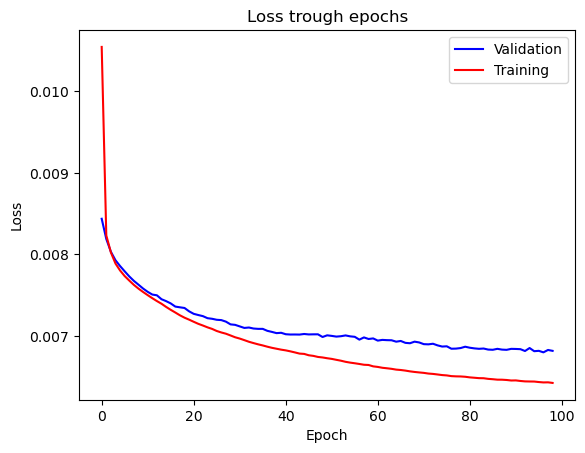

In [21]:
plt.plot(feed_forward_deeper_metrics["val_loss"][:-1],'b-', label="Validation")
plt.plot(feed_forward_deeper_metrics["train_loss"][:-1],'r-', label="Training")
plt.legend()
plt.title("Loss trough epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'MSE')

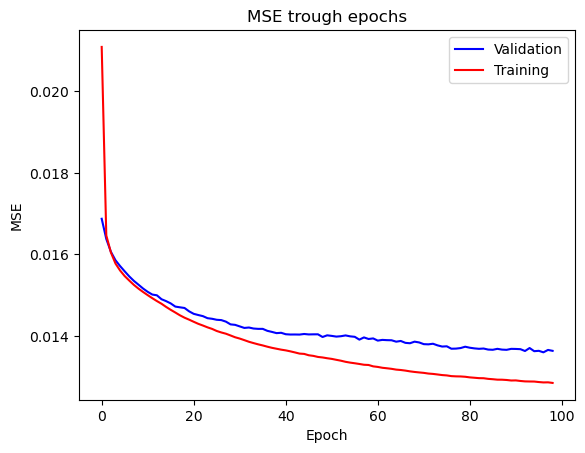

In [22]:
plt.plot(feed_forward_deeper_metrics["val_mse"][:-1],'b-', label="Validation")
plt.plot(feed_forward_deeper_metrics["train_mse"][:-1],'r-', label="Training")
plt.legend()
plt.title("MSE trough epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [23]:
feed_forward_deeper_trainer.test(feed_forward_deeper_model)

C:\Users\jaco0003\Anaconda3\envs\ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.006715614814311266    │
│         test_mse          │   0.013431229628622532    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.006715614814311266, 'test_mse': 0.013431229628622532}]